We want to curate the data from [genesets enriched in PPI](ppi_neighborhoods.ipynb). We will look with special interest at those that involve:

1. Tumor drivers
2. Switches were both isoforms are protein-coding.
3. Both PPI gains and losses.
4. Are coherent with current annotation.

A look at the [networks](../results/networks) yielded 4 candidates:

* BIOCARTA_WNT_PATHWAY
* hnRNP
* BIOCARTA_G1_PATHWAY
* Post-splicing, specifically the subset involved in translation initiation.

In [1]:
source("../data/env/variables.R")
source("~/wisdom/r/data_analysis_environment.R")
source("~/wisdom/r/clean_theme.R")

# read switches that affect PPIs
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & Origin=="Tumor")

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(Origin=="Tumor")

potus <- switches %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript, Recurrence,
           Affects_mutated_feature,PPI,Pannegative,Candidate)

id2symbol <- read_tsv("../data/mutations/proteome_information.txt") %>%
    select(GeneId,Symbol) %>%
    unique

# read interactions
ppi.network <- read_tsv("~/smartas/data/ucsc/interactions_found_more_than_three_times.txt", col_names = F) %>%
    select(-X3) %>%
    set_colnames(c("Gene1","Gene2")) %>%
    merge(id2symbol, by.x = "Gene1", by.y = "GeneId") %>%
    merge(id2symbol, by.x = "Gene2", by.y = "GeneId", suffixes = c("","2")) %>%
    set_colnames(c("Gene1","Gene2","Symbol1","Symbol2"))

# unique drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
    set_colnames(c("Symbol","Tumor")) %>%
    .$Symbol %>%
    unique

# latest version of ucsc genes
latestVersion <- read_tsv("../data/knownGenes.ucsc2013.txt") %>%
    mutate(Transcript = strsplit(name, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           CDS = ifelse(cdsStart == cdsEnd, 0, 1))

# read expression
proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    set_colnames(c("Tumor","GeneId","Symbol","Transcript","TPM","ProteinLength","asEvidence")) %>%
    mutate(asEvidence = as.numeric(asEvidence=="True"))
        
# read interactions
ppi.network <- read_tsv("~/smartas/data/ucsc/interactions_found_more_than_three_times.txt", col_names = F) %>%
    select(-X3) %>%
    set_colnames(c("Gene1","Gene2")) %>%
    merge(id2symbol, by.x = "Gene1", by.y = "GeneId") %>%
    merge(id2symbol, by.x = "Gene2", by.y = "GeneId", suffixes = c("","2")) %>%
    set_colnames(c("Gene1","Gene2","Symbol1","Symbol2"))
    
ppi.file <- "../data/eporta/raw_tables/Switched_interactions_consensus.txt"

## get max number of columns (necessary for reading)
no_col <- max(count.fields(ppi.file,sep = "\t"))
no_col.ppi <- (no_col-6)/2
ppi.cols <- paste(c("Origin","Interaction"), floor(seq(1,no_col.ppi,0.5)), sep="_")

## read table
ppi.split <- read.table(ppi.file,header=F,fill=T,col.names=1:no_col) %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol",ppi.cols)) %>%
    # all Origin columns contail "DDI_match", so we can disregard them
    select(-starts_with("Origin_")) %>%
    # convert from wide to long table format
    reshape2::melt(id.vars = c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol"),
                   value.name = "Interaction") %>%
    select(-variable) %>%
    # remove cases with no interaction described
    filter(Interaction != "") %>%
    # split interaction information
    separate(Interaction, into = c("What","partnerTranscript","Pfams"), sep = "-") %>%
    mutate(What = plyr::revalue(What, replace = c("Gained"="Gain", "Lost"="Loss", "Kept"="Unaffected"))) %>%
    # remove pfams columns (account for different domains for the same interaction)
    select(-Pfams) %>%
    # remove several instances of the same isoform
    unique %>%
    # annotate with switch info
    merge(switches.split %>% filter(Reliable==1)) %>%
    ## remove tumor specific measures
    select(-Recurrence,-Affects_mutated_feature,-PPI,-Pannegative) %>%
    merge(potus, by=c('GeneId','Symbol','Normal_transcript','Tumor_transcript','Candidate'), 
          suffixes=c(".split",".pancancer")) %>%
    # consider only the most abundant isoform as partner: one interaction per pair & only expressed genes
    merge(proteome, by.x = c("Tumor","partnerTranscript"), by.y = c("Tumor","Transcript"),
          suffixes = c(".switch",".partner"))
    
ppi <- ppi.split %>%
    group_by(GeneId.switch,Symbol.switch,Normal_transcript,Tumor_transcript,GeneId.partner,partnerSymbol) %>%
    
    summarise(Unaffected = sum(What=="Unaffected"), Gain = sum(What=="Gain"), Loss = sum(What=="Loss")) %>%
    ungroup() %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript",
                   "partnerGeneId","partnerSymbol","Unaffected","Gain","Loss")) %>%
    mutate(Tag = ifelse(Loss > 0, "Loss", "Unaffected"),
           Tag = ifelse(Gain > 0, "Gain", Tag)) %>%
    merge(switches)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract

Warning message:
: attributes are not identical across measure variables; they will be dropped

# BIOCARTA_WNT_PATHWAY
## Switches in the pathway

In [2]:
BIOCARTA_WNT_PATHWAY <- c(1457,7471,1453,1452,2932,8945,11197,1499,8321,5515,
                          1387,51176,7088,595,1487,51701,324,6885,1855,5467,
                          10023,8312,3065,10454,4089,4609)

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% BIOCARTA_WNT_PATHWAY) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% BIOCARTA_WNT_PATHWAY) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 13

Symbol,DVL1,AXIN1,CREBBP,CSNK1D,CTNNB1,GSK3B,CTBP1,LEF1,CSNK1A1,PPARD,MAP3K7,TLE1,NLK


In [3]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% BIOCARTA_WNT_PATHWAY) %>%
    mutate(Normal_transcript = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 4

[1] "AXIN1"  "CREBBP" "CTNNB1" "PPARD"

In [4]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% BIOCARTA_WNT_PATHWAY & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% BIOCARTA_WNT_PATHWAY & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 1

,1
Symbol,PPARD


In [5]:
source("../data/env/getPPINetwork.R")
library(ggnetwork)
ppiPalette = c("Gain" = "#31a354", "Loss" = "#f03b20", "Unaffected" = "#d9d9d9", "Draw" = "#d9d9d9")

BIOCARTA_WNT_PATHWAY.filt <- switches %>%
    filter(GeneId %in% BIOCARTA_WNT_PATHWAY) %>%
    filter(! GeneId %in% current.switches$GeneId ) %>%
    .$GeneId %>%
    setdiff(BIOCARTA_WNT_PATHWAY,.)

nw <- getPPINetwork(BIOCARTA_WNT_PATHWAY.filt, ppi.network, ppi)

# number of edges
length(nw %e% "Effect")

# add node attributes
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")

ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
    geom_edges(aes(color = Effect, linetype = Consensus)) +
    geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
    scale_color_manual(values = ppiPalette) +
    scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
    scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
    scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
    lims( x = c(-.10, 1.10))+ 
    theme(axis.line=element_blank(),axis.text.x=element_blank(),
          axis.text.y=element_blank(),axis.ticks=element_blank(),
          axis.title.x=element_blank(),axis.title.y=element_blank(),
          legend.position="bottom")

network: Classes for Relational Data
Version 1.13.0 created on 2015-08-31.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.


Attaching package: ‘igraph’

The following objects are masked from ‘package:network’:

    add.edges, add.vertices, %c%, delete.edges, delete.vertices,
    get.edge.attribute, get.edges, get.vertex.attribute, is.bipartite,
    is.directed, list.edge.attributes, list.vertex.attributes, %s%,
    set.edge.attribute, set.vertex.attribute

The following object is masked from ‘package:magrittr’:

    %>%

The following objects are masked from ‘package:dplyr’:

    %>%, as_data_frame, groups, u

[1] 0

ERROR: Error in xj[i, , drop = FALSE]: subscript out of bounds


# hnRNP
## Switches in the pathway

In [6]:
hnRNP <- c("FUS","HNRNPA0","HNRNPA1","HNRNPA2B1","HNRNPA3","HNRNPAB","HNRNPABD",
           "HNRNPC","HNRNPCL1","HNRNPCL2","HNRNPD","HNRNPF","  HNRNPH1","HNRNPH2",
           "HNRNPH3","HNRNPK","HNRNPL","HNRNPM","HNRNPR","HNRNPU","HNRNPUL1",
           "HNRNPUL2","HNRPDL","HNRPLL","HNRPQ","MSL1","MSL2","PCBP1","PCBP2","PCBP3",
           "PCBP4","RALY","RALYL","RARY","RBMX","RBMXL2","SQD","SYNCRIP")

hnRNP <- id2symbol %>%
    filter(Symbol %in% hnRNP) %>%
    .$GeneId

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% hnRNP) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% hnRNP) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 16

Symbol,HNRNPU,HNRNPF,HNRNPH3,PCBP2,HNRNPC,FUS,MSL1,HNRNPUL1,HNRPLL,PCBP4,HNRNPD,HNRPDL,SYNCRIP,HNRNPK,HNRNPH2,RBMX


In [7]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% hnRNP) %>%
    mutate(Normal_transcript = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 8

[1] "PCBP2"   "HNRNPC"  "FUS"     "MSL1"    "PCBP4"   "HNRNPD"  "SYNCRIP"
[8] "HNRNPK"

In [8]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% hnRNP & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% hnRNP & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 1

,1
Symbol,MSL1


In [9]:
hnRNP.filt <- switches %>%
    filter(GeneId %in% hnRNP) %>%
    filter(! GeneId %in% current.switches$GeneId ) %>%
    .$GeneId %>%
    setdiff(hnRNP,.)

nw <- getPPINetwork(hnRNP.filt, ppi.network, ppi)

# number of edges
length(nw %e% "Effect")

# add node attributes
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")

ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
    geom_edges(aes(color = Effect, linetype = Consensus)) +
    geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
    scale_color_manual(values = ppiPalette) +
    scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
    scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
    scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
    lims( x = c(-.10, 1.10))+ 
    theme(axis.line=element_blank(),axis.text.x=element_blank(),
          axis.text.y=element_blank(),axis.ticks=element_blank(),
          axis.title.x=element_blank(),axis.title.y=element_blank(),
          legend.position="bottom")



[1] 1

ERROR: Error in if (nrow(edges[, 1:2]) > nrow(unique(edges[, 1:2]))) {: argument is of length zero


# BIOCARTA_G1_PATHWAY
## Switches in the pathway

In [10]:
BIOCARTA_G1_PATHWAY <-c(1869,7027,2932,1029,1027,1026,983,7042,8900,1030,7040,
                        7043,595,1017,1019,25,5925,6502,7157,1021,1719,993,
                        472,545,3065,4088,4089,898)


# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% BIOCARTA_G1_PATHWAY) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% BIOCARTA_G1_PATHWAY) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 16

Symbol,TGFB2,CDK1,ATM,CDK2,TFDP1,TP53,CCNE1,CDC25A,GSK3B,SKP2,CDKN2A,CDKN2B,ABL1,DHFR,SMAD3,CDK6


In [11]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% BIOCARTA_G1_PATHWAY) %>%
    mutate(Normal_transcript = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 10

[1] "CDK1"   "TFDP1"  "CDC25A" "SKP2"   "CDKN2A" "CDKN2B" "ABL1"   "CDK6"  
 [9] "CDK2"   "SMAD3"

In [12]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% BIOCARTA_G1_PATHWAY & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% BIOCARTA_G1_PATHWAY & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 3

,1,2,3
Symbol,CDKN2A,CDKN2B,SKP2


[1] 7

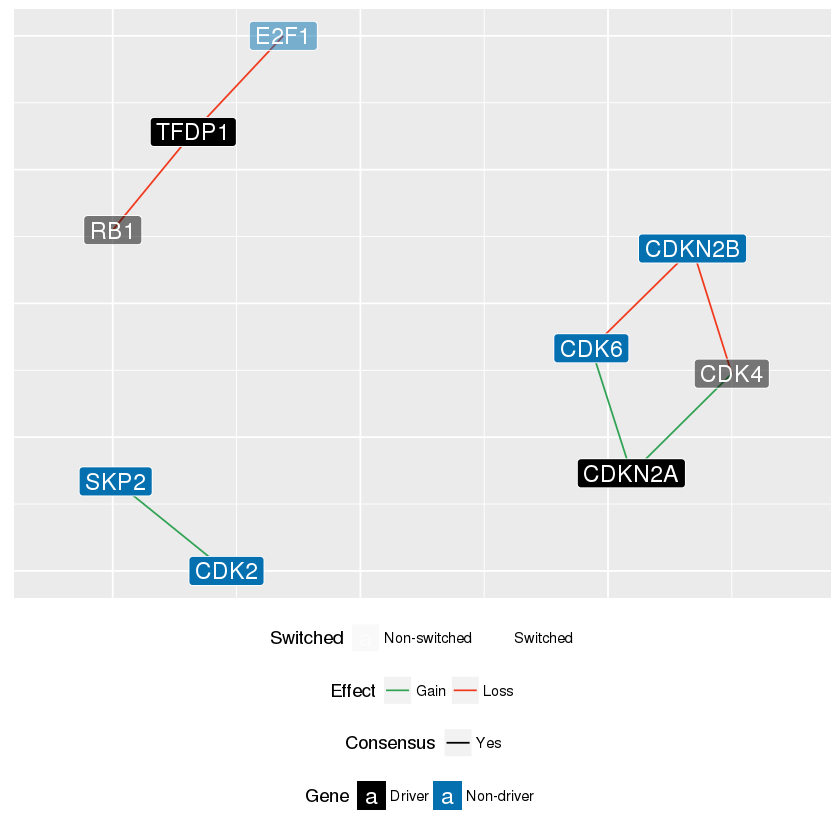

In [13]:
BIOCARTA_G1_PATHWAY.filt <- switches %>%
    filter(GeneId %in% BIOCARTA_G1_PATHWAY) %>%
    filter(! GeneId %in% current.switches$GeneId ) %>%
    .$GeneId %>%
    setdiff(BIOCARTA_G1_PATHWAY,.)

nw <- getPPINetwork(BIOCARTA_G1_PATHWAY.filt, ppi.network, ppi)

# number of edges
length(nw %e% "Effect")

# add node attributes
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")

ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
    geom_edges(aes(color = Effect, linetype = Consensus)) +
    geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
    scale_color_manual(values = ppiPalette) +
    scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
    scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
    scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
    lims( x = c(-.10, 1.10))+ 
    theme(axis.line=element_blank(),axis.text.x=element_blank(),
          axis.text.y=element_blank(),axis.ticks=element_blank(),
          axis.title.x=element_blank(),axis.title.y=element_blank(),
          legend.position="bottom")

# Post-splicing, specifically the subset involved in translation initiation.
## Switches in the pathway

In [14]:
post.splicing <- c("EEF1A1","PABPC1","EIF1","EIF2B1","EIF2B2","EIF2B3","EIF2B4","EIF2B5",
                   "EIF2S1","EIF2S2","EIF2S3","EIF3A","EIF3B","EIF3C","EIF3D","EIF3E","EIF3F",
                   "EIF3G","EIF3H","EIF3I","EIF3J","EIF4A2","EIF4A3","EIF4B","EIF4E",
                   "EIF4EBP1","EIF4G1","EIF5","EIF5B")
post.splicing <- id2symbol %>%
    filter(Symbol %in% post.splicing) %>%
    .$GeneId

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% post.splicing) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% post.splicing) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 13

Symbol,EIF3A,EIF4B,EIF5,EIF3C,EIF2B4,EIF2B5,EIF4A2,EEF1A1,EIF3B,PABPC1,EIF3E,EIF4A3,EIF4E


In [15]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% post.splicing) %>%
    mutate(Normal_transcript = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 6

[1] "EIF2B4" "EIF4A2" "EIF4E"  "EIF3B"  "EIF4B"  "PABPC1"

In [16]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% post.splicing & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% post.splicing & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 1

,1
Symbol,EIF4B


[1] 11

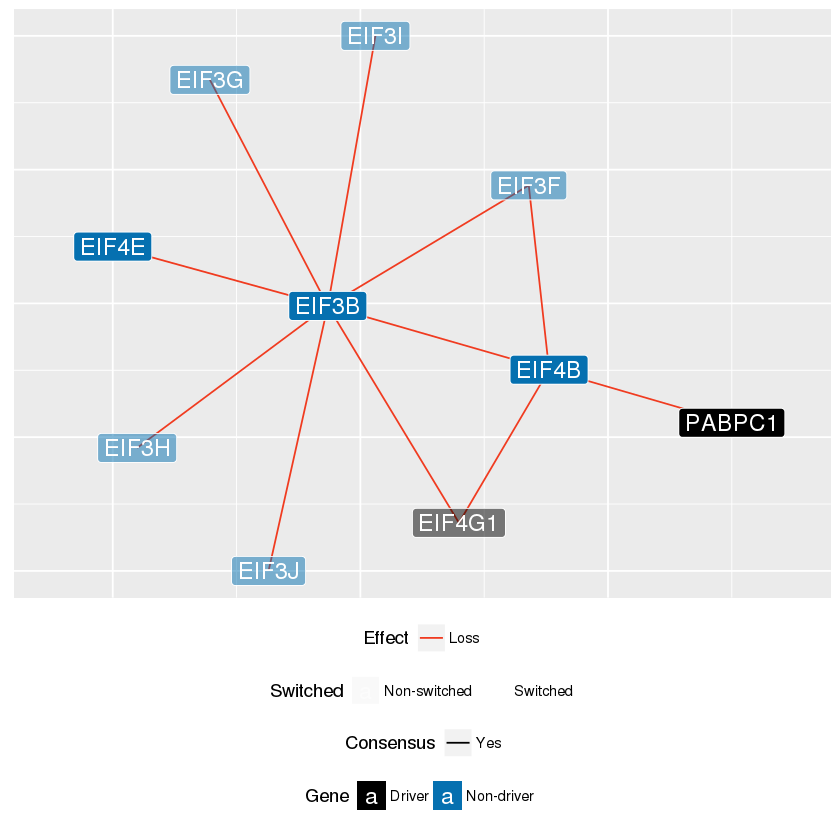

In [17]:
post.splicing.filt <- switches %>%
    filter(GeneId %in% post.splicing) %>%
    filter(! GeneId %in% current.switches$GeneId ) %>%
    .$GeneId %>%
    setdiff(post.splicing,.)

nw <- getPPINetwork(post.splicing.filt, ppi.network, ppi)

# number of edges
length(nw %e% "Effect")

# add node attributes
nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")

ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
    geom_edges(aes(color = Effect, linetype = Consensus)) +
    geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
    scale_color_manual(values = ppiPalette) +
    scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
    scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
    scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
    lims( x = c(-.10, 1.10))+ 
    theme(axis.line=element_blank(),axis.text.x=element_blank(),
          axis.text.y=element_blank(),axis.ticks=element_blank(),
          axis.title.x=element_blank(),axis.title.y=element_blank(),
          legend.position="bottom")